In [134]:
import matplotlib.pyplot as plt
import nltk  
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords  
import pandas as pd
import re
from sklearn.model_selection import train_test_split  
from sklearn.pipeline import Pipeline  
from sklearn.base import BaseEstimator, TransformerMixin  
from sklearn.compose import ColumnTransformer  
from sklearn.preprocessing import LabelEncoder  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay  
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.utils import resample
import string

In [135]:
RANDOM_STATE = 42

## Load Data

### Crypto Tweets / News

#### Read Data

In [136]:
data_raw = pd.read_csv("../res/input/cryptonews.csv")
data_raw.head()

,date,sentiment,source,subject,text,title,url
0,2023-04-05 06:52:09,"{'class': 'negative', 'polarity': -0.03, 'subj...",CoinTelegraph,defi,The compensation process is expected to start ...,Allbridge to first begin repaying stuck bridge...,https://cointelegraph.com/news/allbridge-to-fi...
1,2023-04-05 06:19:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoPotato,bitcoin,On-chain analytics revealed a sentiment shift ...,Bitcoin Hodl Patterns Indicate Cycle Shift to ...,https://cryptopotato.com/bitcoin-hodl-patterns...
2,2023-04-05 05:09:44,"{'class': 'negative', 'polarity': -0.04, 'subj...",CoinTelegraph,bitcoin,"Ether has broken the $1,900 resistance level f...",ETH hits 7-month high ahead of Shanghai and Ca...,https://cointelegraph.com/news/eth-hits-7-mont...
3,2023-04-05 01:09:52,"{'class': 'positive', 'polarity': 0.07, 'subje...",CoinTelegraph,bitcoin,"With a new quarterly production record, Marath...","Marathon Digital posts quarterly record of 2,1...",https://cointelegraph.com/news/marathon-digita...
4,2023-04-04 23:49:00,"{'class': 'positive', 'polarity': 0.4, 'subjec...",CryptoPotato,altcoin,The stablecoin BTG Dol will supposedly become ...,Brazilian Finance Giant BTG Pactual to Issue a...,https://cryptopotato.com/brazilian-finance-gia...


In [137]:
df_tweets = data_raw.copy(deep=True)

In [138]:
df_tweets.describe()

,date,sentiment,source,subject,text,title,url
count,18543,18543,18543,18543,18543,18543,18543
unique,18304,3196,3,6,18131,18511,18543
top,2022-01-14 00:00:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,bitcoin,"Get your daily, bite-sized digest of cryptoass...",Is it Too Late to Buy Shiba Inu? Crypto Expert...,https://cryptonews.com/news/celo-to-be-fastest...
freq,26,4195,8675,6439,326,4,1


In [139]:
df_tweets.isnull().sum()

date         0
sentiment    0
source       0
subject      0
text         0
title        0
url          0
dtype: int64

## Feature Engineering

In [140]:
# Convert sentiment column from string to dict
df_tweets["sentiment"] = df_tweets["sentiment"].apply(eval)

# Split dictionary in separate columns
df_sentiment = pd.json_normalize(df_tweets["sentiment"])
df_tweets = pd.concat([df_tweets, df_sentiment], axis=1)

df_tweets = df_tweets.drop(columns=["sentiment", "url"])
df_tweets = df_tweets.rename(columns={"class": "sentiment"})
df_tweets.head()

,date,source,subject,text,title,sentiment,polarity,subjectivity
0,2023-04-05 06:52:09,CoinTelegraph,defi,The compensation process is expected to start ...,Allbridge to first begin repaying stuck bridge...,negative,-0.03,0.20
1,2023-04-05 06:19:00,CryptoPotato,bitcoin,On-chain analytics revealed a sentiment shift ...,Bitcoin Hodl Patterns Indicate Cycle Shift to ...,neutral,0.00,0.00
2,2023-04-05 05:09:44,CoinTelegraph,bitcoin,"Ether has broken the $1,900 resistance level f...",ETH hits 7-month high ahead of Shanghai and Ca...,negative,-0.04,0.31
3,2023-04-05 01:09:52,CoinTelegraph,bitcoin,"With a new quarterly production record, Marath...","Marathon Digital posts quarterly record of 2,1...",positive,0.07,0.23
4,2023-04-04 23:49:00,CryptoPotato,altcoin,The stablecoin BTG Dol will supposedly become ...,Brazilian Finance Giant BTG Pactual to Issue a...,positive,0.40,0.40


In [141]:
df_tweets["polarity"].describe()

count    18543.000000
mean         0.064634
std          0.198234
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.150000
max          1.000000
Name: polarity, dtype: float64

In [142]:
df_tweets["sentiment"].value_counts()

sentiment
positive    8296
neutral     6417
negative    3830
Name: count, dtype: int64

In [143]:
df_tweets["subjectivity"].value_counts()

subjectivity
0.00    4235
0.50    1219
0.40     702
0.25     624
1.00     606
        ... 
0.92       4
0.04       4
0.89       4
0.93       3
0.91       1
Name: count, Length: 96, dtype: int64

In [144]:
# Convert date column to datetime
df_tweets['date'] = pd.to_datetime(df_tweets['date'], format='mixed', errors='coerce')

# Calculate min and max date
min_date = df_tweets['date'].min()
max_date = df_tweets['date'].max()

print("Min Date:", min_date)
print("Max Date:", max_date)

Min Date: 2021-10-12 20:00:00
Max Date: 2023-04-05 06:52:09


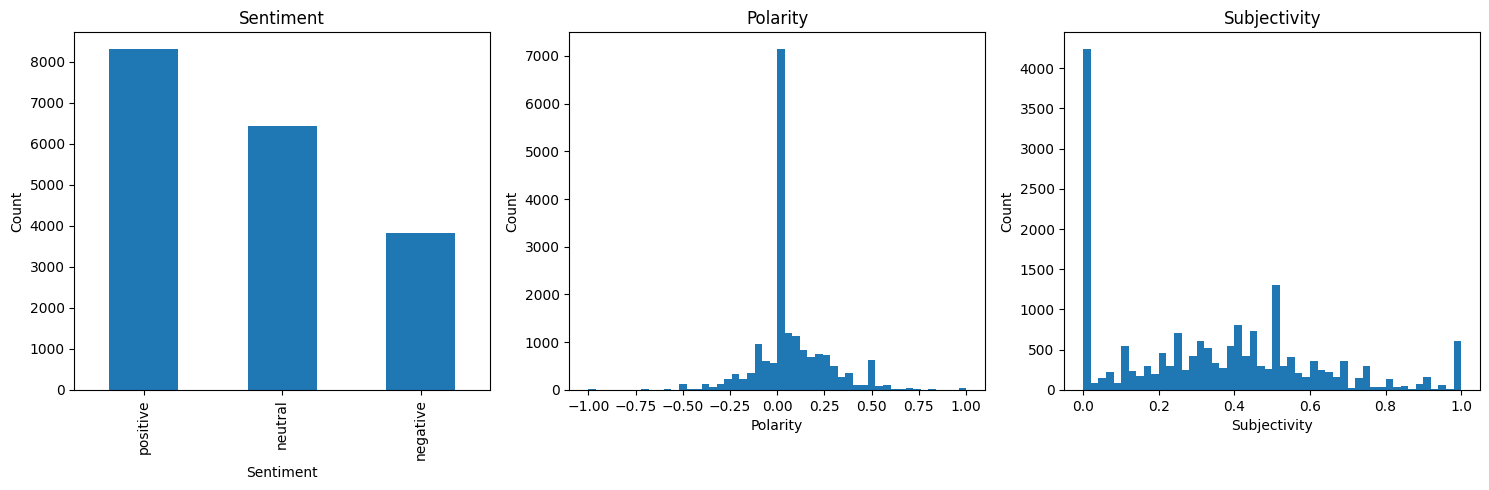

In [145]:
columns_to_plot = ["sentiment", "polarity", "subjectivity"]

fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(5 * len(columns_to_plot), 5))

for i, column in enumerate(columns_to_plot):
    ax = axes[i] 
    if pd.api.types.is_numeric_dtype(df_tweets[column]):
        df_tweets[column].plot.hist(ax=ax, bins=50)
    else:
        df_tweets[column].value_counts().plot.bar(ax=ax)
    ax.set_title(column.capitalize())
    ax.set_xlabel(column.capitalize())
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

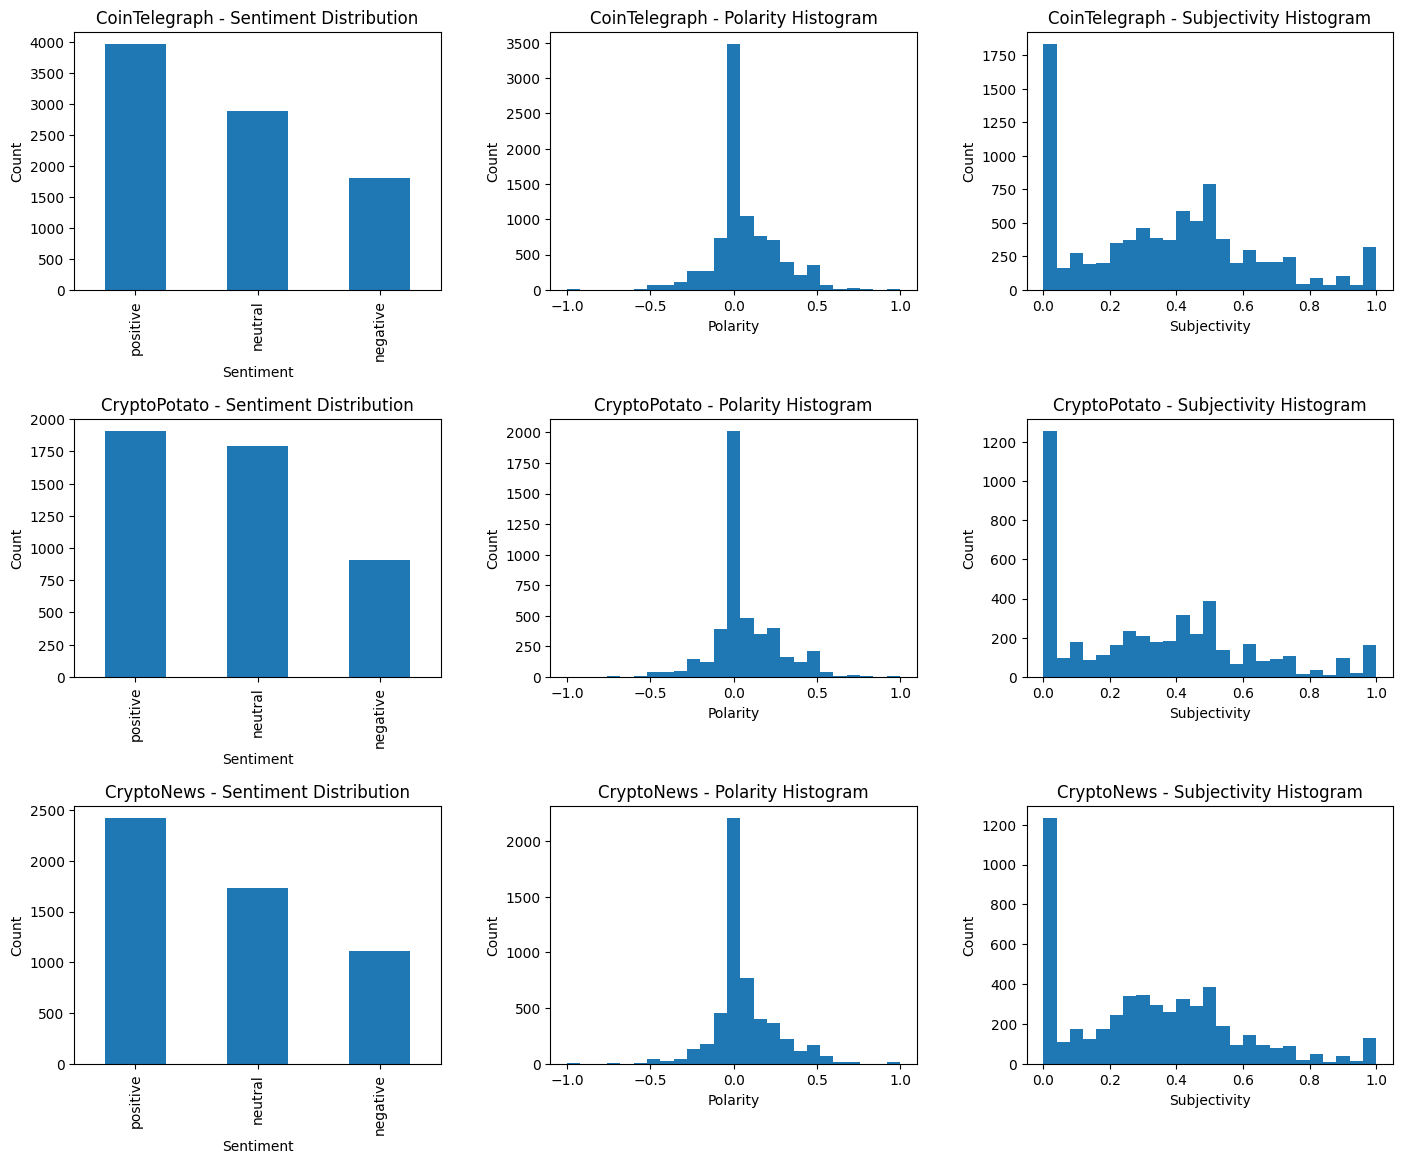

In [146]:
unique_sources = df_tweets["source"].unique()
n_rows = len(unique_sources) # Number of Sources
n_columns = len(columns_to_plot) # Number of columns to analyse

fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 4 * n_columns))
fig.tight_layout(pad=5)

for i, source in enumerate(unique_sources):
    source_data = df_tweets[df_tweets["source"] == source]

    for j, column in enumerate(columns_to_plot):
        ax = axes[i, j] if n_rows > 1 else axes[j]

        if pd.api.types.is_numeric_dtype(source_data[column]):
            source_data[column].plot.hist(ax=ax, bins=25)
            ax.set_title(f'{source} - {column.capitalize()} Histogram')
            ax.set_ylabel('Count')
            ax.set_xlabel(column.capitalize())
        else:
            # Plot categorical columns as bar charts
            source_data[column].value_counts().plot.bar(ax=ax)
            ax.set_title(f'{source} - {column.capitalize()} Distribution')
            ax.set_ylabel('Count')
            ax.set_xlabel(column.capitalize())

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

## Model Pipeline

### Feature Engineering

In [147]:
# Define the target and features
target = "sentiment"
features = ["text", "title", "subject", "source"]

X = df_tweets[features]
y = df_tweets[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### Dataset Balancing

In [148]:
# Create a second training dataset with balanced classes
sentiment_counts = df_tweets[target].value_counts()

# Get the category with the least amount of samples
max_count = sentiment_counts.max()

balanced_dfs = []
for sentiment, count in sentiment_counts.items():
    df_sentiment = df_tweets[df_tweets[target] == sentiment]
    if count < max_count:
        df_sentiment_resampled = resample(df_sentiment, replace=True, n_samples=max_count, random_state=RANDOM_STATE)
        balanced_dfs.append(df_sentiment_resampled)
    else:
        balanced_dfs.append(df_sentiment)
        
df_tweets_balanced = pd.concat(balanced_dfs)

X_blanced = df_tweets_balanced[features]
y_blanced = df_tweets_balanced[target]

X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_blanced, y_blanced, test_size=0.2, random_state=RANDOM_STATE)

### Classification Pipeline

In [149]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("punkt_tab")

class NLTKTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(self.tokenize)
    
    def tokenize(self, text):
        text = re.sub(r'\W', ' ', str(text))  
        tokens = word_tokenize(text.lower())  
        filtered_tokens = [t for t in tokens if t not in self.stop_words and t not in string.punctuation]  
        return ' '.join(filtered_tokens)  
    
class CompoundWordSplitter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def __split_compound(self, word):
        # Simple Heuristic for segmenting compound words
        # This is a placeholder and should be replaced with a more robust method
        return re.findall(r'[A-Z]?[a-z]+|[A-Z]+(?=[A-Z]|$)', word)
    
    def fit(self, X, y=None):
        return self
    
    def split_compounds(self, text):
        words = text.split()
        split_words = []
        for word in words:
            split_words.extend(self.__split_compound(word))
        return ' '.join(split_words)
    
    def transform(self, X):
        return X.apply(self.split_compounds)

[nltk_data] Downloading package punkt to C:\Users\Niklas
[nltk_data]     Seither\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Niklas
[nltk_data]     Seither\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Niklas
[nltk_data]     Seither\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [150]:
# Create a list of transformers dynamically
transformers = [
    (f'nltk_{feature}', Pipeline([
        ('compound_splitter', CompoundWordSplitter()),
        ('tokenizer', NLTKTokenizer()),
        ('tfidf', TfidfVectorizer())
    ]), feature) for feature in features
]

pipeline_sentiment_nltk = Pipeline([
    ('preprocessing', ColumnTransformer(transformers, remainder='drop')),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

pipeline_sentiment_nltk_balanced = Pipeline([
    ('preprocessing', ColumnTransformer(transformers, remainder='drop')),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

In [151]:
pipeline_sentiment_nltk.fit(X_train, y_train)
pipeline_sentiment_nltk_balanced.fit(X_train_balanced, y_train_balanced)

print("Accuracy (NLTK Pipeline):", pipeline_sentiment_nltk.score(X_test, y_test))
print("Accuracy (NLTK Pipeline Balanced):", pipeline_sentiment_nltk_balanced.score(X_test_balanced, y_test_balanced))

Accuracy (NLTK Pipeline): 0.7705581019142625
Accuracy (NLTK Pipeline Balanced): 0.8812776215347529


## Evaluation

In [152]:
def evaluate_model(model, X_test, y_test, model_name):  
    y_pred = model.predict(X_test)  
    print(f"Classification Report for {model_name}:")  
    print(classification_report(y_test, y_pred))    
    
    print(f"Confusion Matrix for {model_name}:")  
    cm = confusion_matrix(y_test, y_pred, normalize='true')  
    print(cm)  
      
    # Display normalized confusion matrix as a graphic
    labels = sorted(list( set(y_test))) #set(y_train) |
    print(labels)  
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)  
    disp.plot(cmap=plt.cm.Blues)  
    
    plt.title(f"Normalized Confusion Matrix for {model_name}")  
    plt.show()

Classification Report for Simple RandomForest Model (nltk & preprocessing) (unbalanced Training and Testdata):
              precision    recall  f1-score   support

    negative       0.80      0.52      0.63       745
     neutral       0.72      0.89      0.80      1298
    positive       0.81      0.79      0.80      1666

    accuracy                           0.77      3709
   macro avg       0.78      0.73      0.74      3709
weighted avg       0.78      0.77      0.76      3709

Confusion Matrix for Simple RandomForest Model (nltk & preprocessing) (unbalanced Training and Testdata):
[[0.51543624 0.22684564 0.25771812]
 [0.01771957 0.88906009 0.09322034]
 [0.04381753 0.16386555 0.79231693]]
['negative', 'neutral', 'positive']


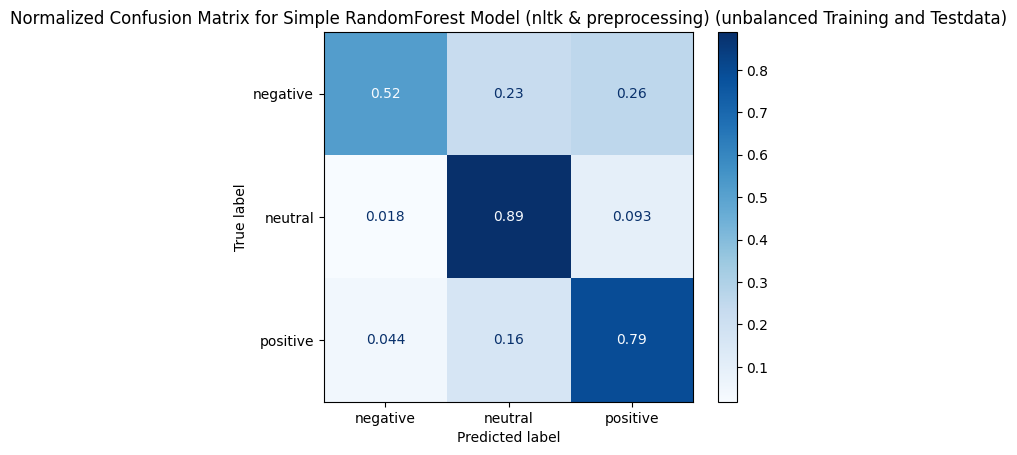

In [153]:
evaluate_model(pipeline_sentiment_nltk, X_test, y_test, "Simple RandomForest Model (nltk & preprocessing) (unbalanced Training and Testdata)")

Classification Report for Simple RandomForest Model (nltk & preprocessing) (unbalanced Training and balanced Testdata):
              precision    recall  f1-score   support

    negative       0.99      0.92      0.95      1657
     neutral       0.94      0.98      0.96      1621
    positive       0.94      0.96      0.95      1700

    accuracy                           0.95      4978
   macro avg       0.95      0.95      0.95      4978
weighted avg       0.95      0.95      0.95      4978

Confusion Matrix for Simple RandomForest Model (nltk & preprocessing) (unbalanced Training and balanced Testdata):
[[0.92275196 0.03077852 0.04646952]
 [0.00246761 0.97779149 0.0197409 ]
 [0.00764706 0.03235294 0.96      ]]
['negative', 'neutral', 'positive']


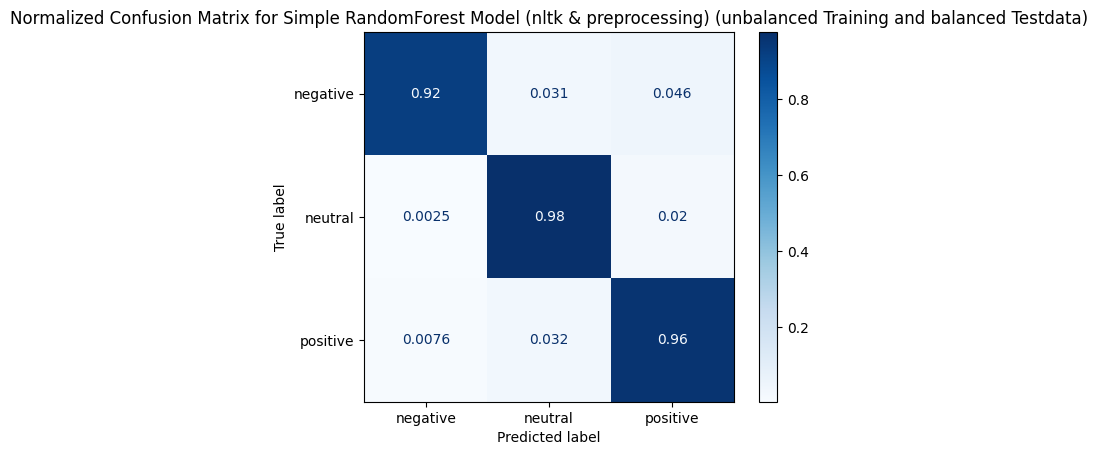

In [154]:
evaluate_model(pipeline_sentiment_nltk, X_test_balanced, y_test_balanced, "Simple RandomForest Model (nltk & preprocessing) (unbalanced Training and balanced Testdata)")

Classification Report for Simple RandomForest Model (nltk & preprocessing) (balanced Training and Testdata):
              precision    recall  f1-score   support

    negative       0.92      0.94      0.93      1657
     neutral       0.82      0.95      0.88      1621
    positive       0.91      0.76      0.83      1700

    accuracy                           0.88      4978
   macro avg       0.89      0.88      0.88      4978
weighted avg       0.89      0.88      0.88      4978

Confusion Matrix for Simple RandomForest Model (nltk & preprocessing) (balanced Training and Testdata):
[[0.93964997 0.02715751 0.03319252]
 [0.00987045 0.95003085 0.0400987 ]
 [0.07176471 0.16941176 0.75882353]]
['negative', 'neutral', 'positive']


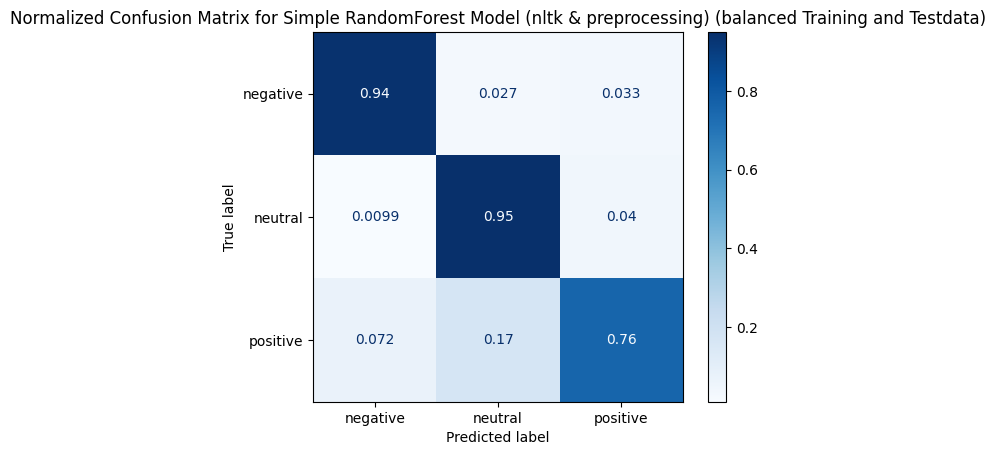

In [155]:
evaluate_model(pipeline_sentiment_nltk_balanced, X_test_balanced, y_test_balanced, "Simple RandomForest Model (nltk & preprocessing) (balanced Training and Testdata)")